In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [3]:
import tensorflow as tf
tf.__version__

'1.4.0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4297181326814443584, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 6944984549248652091
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 6379510895713926639
 physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1", name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 967821898263753195
 physical_device_desc: "device: 2, name: GeForce GTX 1080 Ti, pci bus id: 0000:87:00.0, compute capability: 6.1", name: "/device:GPU:3"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 17747736009136444546
 physical_device

In [5]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop

from keras.models import Model

from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.applications.nasnet import NASNetLarge, preprocess_input

from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils import np_utils

from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
K.image_dim_ordering()

'tf'

In [7]:
output_classes = 2
batch_size = 8
img_height, img_width = 331, 331
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 59168
nb_validation_samples = 18384
nb_test_samples = 967

In [8]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test'

In [9]:
# if K.image_data_format() == 'channels_first':
#     input_shape = (3, img_width, img_height)
# else:
#     input_shape = (img_width, img_height, 3)

In [10]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/train/ 0
data/train/normal 18744
data/train/malignant 40424
******************************
data/validation 0
data/validation/normal 5872
data/validation/malignant 12512
******************************
data/test 0
data/test/normal 312
data/test/malignant 655


In [11]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')


Found 59168 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [12]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(output_classes, activation=tf.nn.softmax)(x)

model = Model(inputs=base_model.input,outputs=prediction)

In [13]:
# sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)
# eve_opt = Eve(lr=1e-4, decay=1E-4, beta_1=0.9, beta_2=0.999, beta_3=0.999, small_k=0.1, big_K=10, epsilon=1e-08)

model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [15]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
7396/7396 [==============================] - 6760s 914ms/step - loss: 0.4031 - acc: 0.8398 - val_loss: 0.3267 - val_acc: 0.8536
Epoch 2/50
7396/7396 [==============================] - 6769s 915ms/step - loss: 0.1694 - acc: 0.9374 - val_loss: 0.4207 - val_acc: 0.8263
Epoch 3/50
7396/7396 [==============================] - 6768s 915ms/step - loss: 0.0662 - acc: 0.9780 - val_loss: 0.2410 - val_acc: 0.9111
Epoch 4/50
7396/7396 [==============================] - 6766s 915ms/step - loss: 0.0304 - acc: 0.9901 - val_loss: 0.2260 - val_acc: 0.9339
Epoch 5/50
7396/7396 [==============================] - 6764s 915ms/step - loss: 0.0215 - acc: 0.9937 - val_loss: 0.2122 - val_acc: 0.9404
Epoch 6/50
7396/7396 [==============================] - 6769s 915ms/step - loss: 0.0148 - acc: 0.9957 - val_loss: 0.2469 - val_acc: 0.9232
Epoch 7/50
7396/7396 [==============================] - 6783s 917ms/step - loss: 0.0107 - acc: 0.9970 - val_loss: 0.2332 - val_acc: 0.9415
Epoch 8/50
7396/7396 [=====

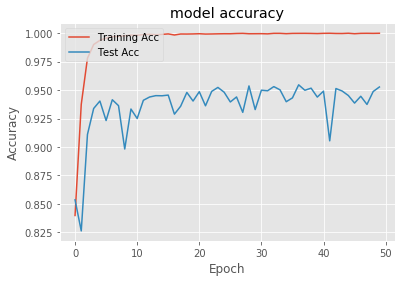

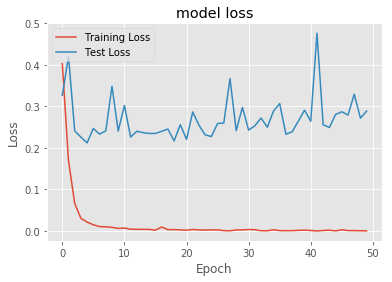

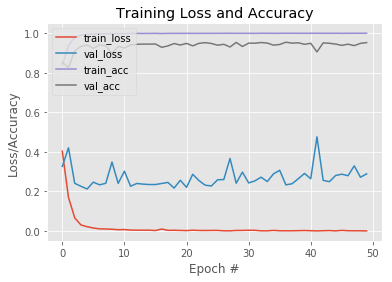

In [17]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [18]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.3312794250052559
Validation Accuracy:  0.95


In [19]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

121/120 [==============================] - 31s 257ms/step
No of errors = 47/967


Confusion Matrix
[[637  18]
 [ 29 283]]


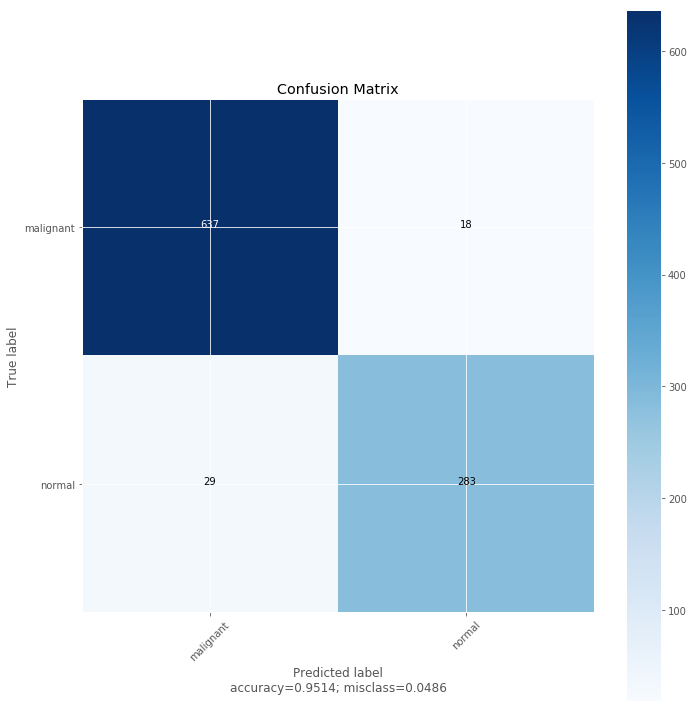

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1])
y_pred_binary = y_pred_probabilities#label_binarize(y_pred_probabilities, classes=[0, 1, 2, 3, 4])
n_classes=2
lw=2

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[637  18]
 [ 29 283]]
              precision    recall  f1-score   support

   malignant       0.96      0.97      0.96       655
      normal       0.94      0.91      0.92       312

   micro avg       0.95      0.95      0.95       967
   macro avg       0.95      0.94      0.94       967
weighted avg       0.95      0.95      0.95       967



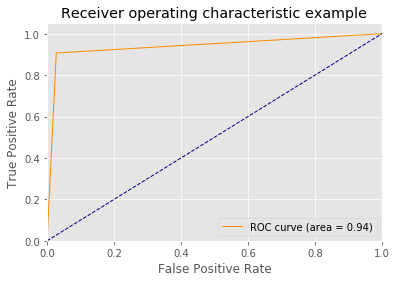

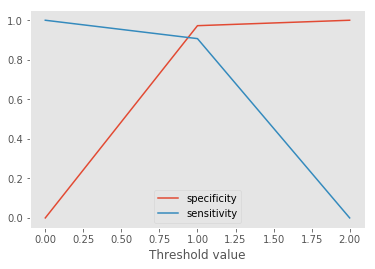

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()



In [24]:
model.save('models/5.NASNetLarge-ISIB19-DataSet-Model.h5')
model.save_weights('models/5.NASNetLarge-ISIB19-Weights.h5')